In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/My\ Drive/CPM_Pytorch

/content/drive/My Drive/CPM_Pytorch


In [5]:
import matplotlib
matplotlib.use('TKAgg')

from data_loader.dataLoader import CarDataset as Mydata
from model.cpm import CPM
from src.util import heatmap_image,save_images,PCK

import os
import torch
import torch.optim as optim
import torch.nn as nn
import configparser

from torch.autograd import Variable
from torch.utils.data import DataLoader

In [7]:
#Hyperparams
config = configparser.ConfigParser()
config.read('conf_online.text')

train_data_dir = config.get('data', 'train_data_dir')
model_save_dir=config.get('data', 'model_save_dir')

save_dir = config.get('data', 'save_dir')

learning_rate = config.getfloat('training', 'learning_rate')
batch_size = config.getint('training', 'batch_size')
epochs = config.getint('training', 'epochs')
begin_epoch = config.getint('training', 'begin_epoch')
n_keypoints=config.getint('training', 'n_keypoints')


In [8]:
cuda = torch.cuda.is_available()
 

if not os.path.exists(save_dir):
    os.mkdir(save_dir)

In [12]:
# *********************** Build dataset ***********************
train_data = Mydata(data_dir=train_data_dir)


print ('Train dataset total number of images sequence is ----' + str(len(train_data)))

# Data Loader
train_dataset = DataLoader(train_data, batch_size=batch_size, shuffle=True)

Train dataset total number of images sequence is ----717


In [14]:
net = CPM(out_c=n_keypoints)

device_ids = [0]  
if cuda:
    net = net.cuda(device_ids[0])
    net = nn.DataParallel(net, device_ids=device_ids)


if begin_epoch > 0:
    save_path = model_save_dir + str(begin_epoch) + '.pth'
    state_dict = torch.load(save_path)
    net.load_state_dict(state_dict)

In [17]:
def train():
    # *********************** initialize optimizer ***********************
    optimizer = optim.Adam(params=net.parameters(), lr=learning_rate, betas=(0.5, 0.999))
    criterion = nn.MSELoss(size_average=True)                       # loss function MSE average

    net.train()
    for epoch in range(begin_epoch, epochs + 1):
        print ('epoch....................' + str(epoch))
        
        for step, (image, label_map, center_map, imgs) in enumerate(train_dataset):
            
            image = Variable(image.cuda() if cuda else image)                   # 4D Tensor
            # Batch_size  *  3  *  width(368)  *  height(368)

            # 4D Tensor to 5D Tensor
            label_map = torch.stack([label_map]*6, dim=1)
            # Batch_size  *  21 *   45  *  45
            # Batch_size  *   6 *   21  *  45  *  45
            label_map = Variable(label_map.cuda() if cuda else label_map)

            center_map = Variable(center_map.cuda() if cuda else center_map)    # 4D Tensor
            # Batch_size  *  width(368) * height(368)

            optimizer.zero_grad()
            pred_6 = net(image, center_map)  # 5D tensor:  batch size * stages * 21 * 45 * 45 #This is huge

            # ******************** calculate loss of each joints ********************
            loss = criterion(pred_6, label_map)

            # backward
            loss.backward()
            loss=loss.detach()
            #import ipdb
            #ipdb.set_trace()
            
            optimizer.step() #Not using SGD
            #gc.collect()

            if step % 10 == 0:
                print ('--step .....' + str(step))
                print ('--loss ',loss.item()*10000)
                gb_factor=10**9
                print('--gpu memory=',torch.cuda.memory_allocated()/gb_factor)

            if step % 40 == 0:
              torch.save(net.state_dict(), os.path.join(save_dir, 'model_epoch{:d}.pth'.format(epoch)))
            #    save_images(label_map[:, 5, :, :, :], pred_6[:, 5, :, :, :], step, epoch, imgs)

        if epoch % 5 == 0:
            torch.save(net.state_dict(), os.path.join(save_dir, 'model_epoch{:d}.pth'.format(epoch)))
        
            #Delete tensors from memory
            #del image,label_map,center_map,pred_6

    print ('train done!')

In [ ]:
train()

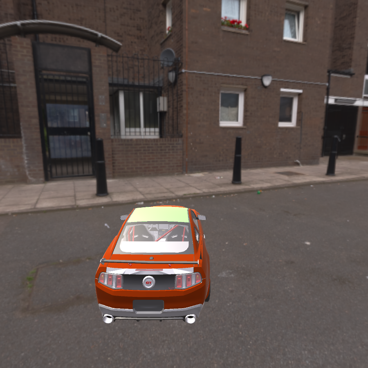

In [115]:
from PIL import Image, ImageDraw
img=Image.open('/content/drive/My Drive/Final Data/mustang/Images/Trial_Screenshot1.PNG')
img=img.resize((368,368))
img

In [116]:
image,labels,center_map,img_str=train_data[0]


pred_6=net(torch.unsqueeze(image,dim=0),torch.unsqueeze(center_map,dim=0))[0][-1] #Final stage output

output=pred_6.clone().detach()*0

In [118]:
def get_locations(pred_6):
  locations=[]
  label_locations=[]
  for keypoint_map in pred_6:
    
    flat_tensor=keypoint_map.view(1,-1)
    val=torch.argmax(flat_tensor)
    locations.append((val//45*(368//45),(val%45)*(368//45)))
  return locations  

locations=get_locations(pred_6)

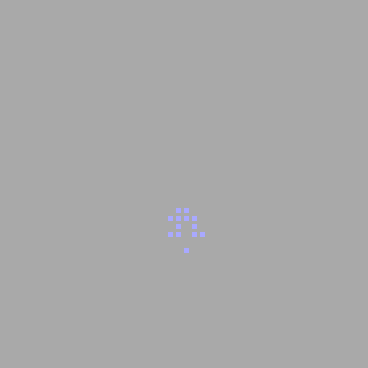

In [125]:
def generate_output_image(output,locations):
  
  output_image=transforms.ToPILImage()(output.cpu()).resize((368,368))
  draw = ImageDraw.Draw(output_image)
  for x,y in locations:
    draw.ellipse((y, x, y+5, x+5), fill = 'blue', outline ='blue')
  output_image.putalpha(86)
  return output_image

output_image=generate_output_image(output,locations)
output_image

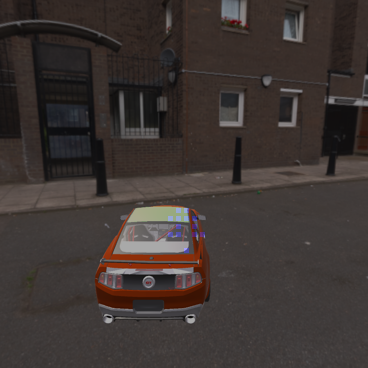

In [126]:
background=img.copy()
background.paste(output_image,(0,0),output_image)
background
#output_image

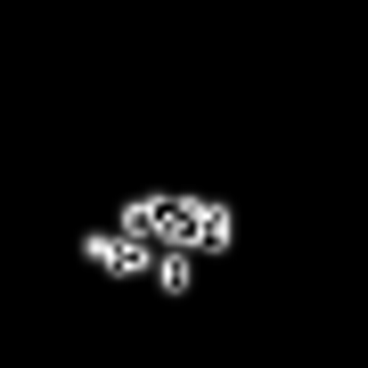

In [55]:
cum_labels=torch.sum(labels,axis=0)
transforms.ToPILImage()(cum_labels).resize((368,368))

[(tensor(29, device='cuda:0'), tensor(19, device='cuda:0')),
 (tensor(27, device='cuda:0'), tensor(25, device='cuda:0')),
 (tensor(28, device='cuda:0'), tensor(22, device='cuda:0')),
 (tensor(28, device='cuda:0'), tensor(21, device='cuda:0')),
 (tensor(28, device='cuda:0'), tensor(22, device='cuda:0')),
 (tensor(27, device='cuda:0'), tensor(25, device='cuda:0')),
 (tensor(28, device='cuda:0'), tensor(23, device='cuda:0')),
 (tensor(28, device='cuda:0'), tensor(22, device='cuda:0')),
 (tensor(29, device='cuda:0'), tensor(15, device='cuda:0')),
 (tensor(29, device='cuda:0'), tensor(12, device='cuda:0')),
 (tensor(25, device='cuda:0'), tensor(22, device='cuda:0')),
 (tensor(26, device='cuda:0'), tensor(23, device='cuda:0')),
 (tensor(27, device='cuda:0'), tensor(23, device='cuda:0')),
 (tensor(27, device='cuda:0'), tensor(22, device='cuda:0')),
 (tensor(25, device='cuda:0'), tensor(22, device='cuda:0')),
 (tensor(26, device='cuda:0'), tensor(22, device='cuda:0')),
 (tensor(25, device='cud